[![Map Pipeline](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml)
[![Lint](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml)
<a target="_blank" href="https://colab.research.google.com/github/YertleTurtleGit/depth-from-normals">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Introduction


This algorithm estimates a 3d integral with the normal mapping. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.


# Source code


## Imports


In [1]:
import numpy as np
import cv2 as cv
from scipy.integrate import cumulative_trapezoid
from skimage import io
from math import sin, cos, radians
from threading import Thread, Lock
from typing import List
from matplotlib import pyplot as plt


## Input & Settings


In [2]:
NORMAL_MAP_A_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_a.png"  # @param {type: "string"}
NORMAL_MAP_B_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_b.png"  
NORMAL_MAP_A_IMAGE: np.ndarray = io.imread(NORMAL_MAP_A_PATH)
NORMAL_MAP_B_IMAGE: np.ndarray = io.imread(NORMAL_MAP_B_PATH)

NORMAL_MAP_IS_OPEN_GL: bool = True  # @param {type: "boolean"}
TARGET_ITERATION_COUNT: int = 1000  # @param {type: "integer"}
MAX_THREAD_COUNT: int = 4  # @param {type: "integer"}

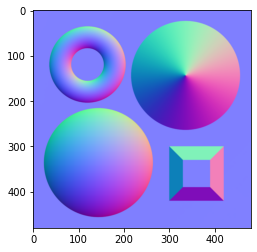

In [3]:
# Source: commons.wikimedia.org
plt.imshow(NORMAL_MAP_A_IMAGE)

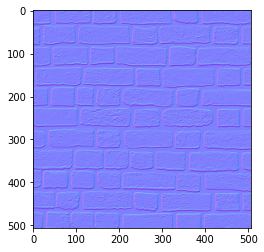

In [4]:
# Source: learnopengl.com
plt.imshow(NORMAL_MAP_B_IMAGE)

## Sub-methods


### Gradient Map

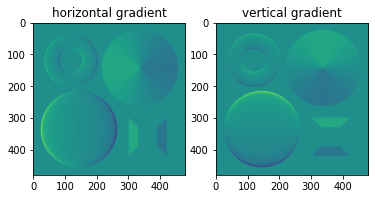

In [5]:
def calculate_gradient_map(
    normal_map: np.ndarray, normal_map_is_open_gl: bool = True
) -> np.ndarray:
    width, height, _ = normal_map.shape
    normal_map = normal_map[:, :, :3]  # Remove alpha channel if present.
    normal_map = ((normal_map / 255) - 0.5) * 2  # Transform from [0, 255] to [-1, 1].
    if not normal_map_is_open_gl:
        normal_map[:, :, 1] *= -1  # Invert green/y channel if not OpenGL.

    gradient_map = np.empty((width, height, 2), dtype=np.float64)
    gradient_map[:, :, 0] = -normal_map[:, :, 0] / normal_map[:, :, 2]
    gradient_map[:, :, 1] = normal_map[:, :, 1] / normal_map[:, :, 2]
    return gradient_map


gradient_map_image = calculate_gradient_map(NORMAL_MAP_A_IMAGE)
gradient_map_image -= np.min(gradient_map_image)
gradient_map_image /= np.max(gradient_map_image)
gradient_map_image = (gradient_map_image * 255).astype(np.uint8)

_, axis_array = plt.subplots(1, 2)
axis_array[0].set_title("horizontal gradient")
axis_array[0].imshow(gradient_map_image[:, :, 0])
axis_array[1].set_title("vertical gradient")
axis_array[1].imshow(gradient_map_image[:, :, 1])


### Rotation

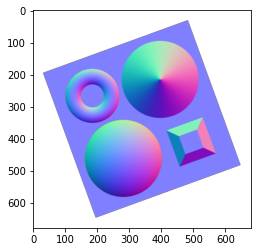

In [6]:
def rotate(image: np.ndarray, angle: float, resize: bool = True) -> np.ndarray:
    from math import sqrt, ceil
    from cv2 import getRotationMatrix2D, warpAffine

    height, width = image.shape[:2]
    new_height: int = height
    new_width: int = width

    if resize:
        # TODO optimize new resolution
        image_diagonal_length: int = ceil(sqrt(height**2 + width**2))
        angle_radians = radians(angle)
        new_height = image_diagonal_length
        new_width = image_diagonal_length

    channel_count = image.shape[2] if len(image.shape) == 3 else 1
    shape = (
        (new_height, new_width)
        if channel_count == 1
        else (new_height, new_width, channel_count)
    )
    rotated_image = np.zeros(shape, dtype=image.dtype)

    if resize:
        rotated_image[
            (new_height - height) // 2 : (new_height + height) // 2,
            (new_width - width) // 2 : (new_width + width) // 2,
        ] = image
    else:
        rotated_image = image

    rotation_matrix = getRotationMatrix2D((new_width // 2, new_height // 2), angle, 1)
    return warpAffine(rotated_image, rotation_matrix, rotated_image.shape[:2])


plt.imshow(rotate(NORMAL_MAP_A_IMAGE, 20))


In [7]:
def estimate_depth_map(
    normal_map: np.ndarray,
    normal_map_is_open_gl: bool = True,
    target_iteration_count: int = 1000,
    max_thread_count: int = 1,
) -> np.ndarray:
    """Estimates a depth mapping from a given normal mapping.

    Parameters
    ----------
    normal_map_path : str
        The URI or simple file path to the normal mapping.
    normal_map_is_open_gl : bool, optional
        Set to `False` if the normal map is in DirectX format with flipped green/y channel, by default `True`.
    target_iteration_count : int, optional
        The target iteration count of the depth mapping defined how many iterations of integrations are performed, by default `1`.
    max_thread_count : int, optional
        The maximum number of threads used to calculate the depth mapping, by default `1`.

    Returns
    -------
    np.ndarray
        The depth mapping as image array.
    """
    width, height, _ = normal_map.shape
    gradient_map = calculate_gradient_map(normal_map, normal_map_is_open_gl)

    isotropic_integral = np.zeros((width, height))
    isotropic_integral_lock: Lock = Lock()

    def integrate_anisotropic(angles: List[float]):

        for angle in angles:

            anisotropic_gradient_map = rotate(
                gradient_map[:, :, 0] * cos(radians(angle))
                + gradient_map[:, :, 1] * sin(radians(angle)),
                angle,
            ).astype(np.float64)

            anisotropic_integral = rotate(
                cumulative_trapezoid(anisotropic_gradient_map),
                -angle,
            ).astype(np.float64)

            top_crop: int = (anisotropic_integral.shape[0] - height) // 2
            left_crop: int = (anisotropic_integral.shape[1] - width) // 2
            anisotropic_integral = anisotropic_integral[
                top_crop : top_crop + height,
                left_crop : left_crop + width,
            ]

            isotropic_integral_lock.acquire()
            nonlocal isotropic_integral
            isotropic_integral += anisotropic_integral
            isotropic_integral_lock.release()

    max_thread_count = max(max_thread_count, 1)
    anisotropic_integral_threads: List[Thread] = []
    angle_per_thread: float = 360 / max_thread_count
    iterations_per_thread: int = max(
        round(target_iteration_count / max_thread_count), 1
    )

    for thread_id in range(0, max_thread_count):
        angle_start_point: float = thread_id * angle_per_thread
        angle_stop_point: float = (thread_id + 1) * angle_per_thread

        angles = np.linspace(
            angle_start_point,
            angle_stop_point,
            iterations_per_thread,
            endpoint=False,
        )

        thread = Thread(target=integrate_anisotropic, args=(angles,))
        thread.start()
        anisotropic_integral_threads.append(thread)

    for thread in anisotropic_integral_threads:
        thread.join()

    depth_map = isotropic_integral

    # Normalizes depth values to [0, 1].
    depth_map -= np.min(depth_map)
    depth_map /= np.max(depth_map)

    depth_map *= 255  # Transform from [0, 1] to [0, 255].

    return depth_map


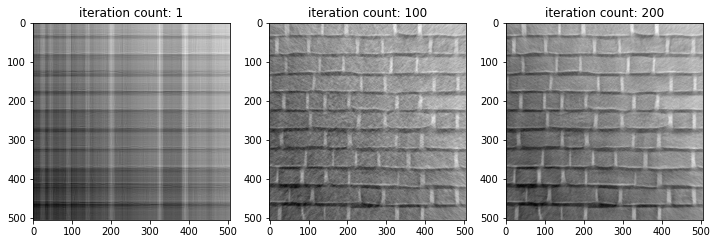

In [32]:
figure, axis_array = plt.subplots(1, 3)
figure.set_size_inches((12, 5))

for index in range(3):
    iteration_count = max(index * 100, 1)
    axis_array[index].set_title(f"iteration count: {iteration_count}")

    depth_map_image: np.ndarray = estimate_depth_map(
        NORMAL_MAP_B_IMAGE,
        normal_map_is_open_gl=NORMAL_MAP_IS_OPEN_GL,
        target_iteration_count=iteration_count,
        max_thread_count=MAX_THREAD_COUNT,
    )

    axis_array[index].imshow(depth_map_image, cmap="gray")


## Example usage


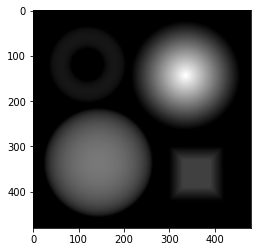

In [8]:
depth_map_image: np.ndarray = estimate_depth_map(
    NORMAL_MAP_A_IMAGE,
    normal_map_is_open_gl=NORMAL_MAP_IS_OPEN_GL,
    target_iteration_count=TARGET_ITERATION_COUNT,
    max_thread_count=MAX_THREAD_COUNT,
)

plt.imshow(depth_map_image, cmap="gray")
